# **Load, analyse and visualize dataset**

In [1]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import numpy as np
import cv2
import os

In [2]:
# Define paths

base_path = "C:/Users/funmi/GitRepositories/Road-Sign-Detection"
training_folder = os.path.join(base_path, 'traffic_Data/TRAIN')
val_folder = os.path.join(base_path, 'traffic_Data/VAL')

# Load labels
labels_df = pd.read_csv(os.path.join(base_path, 'labels.csv'))

# Create mapping between class names and indices
class_names = sorted(labels_df['ClassId'].unique())
num_classes = len(class_names)
class_name_to_index = {class_name: index for index, class_name in enumerate(class_names)}

# **Preprocessing steps**

In [3]:
# Image dimensions and batch size
image_shape = (75,75)
batch_size = 32

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(rescale = 1./255, 
                            rotation_range=10, # rotate image by 10 degrees
                            width_shift_range=0.1, # shift images horizontally by 10%
                            height_shift_range=0.1, # shift images vertically by 10%
                            shear_range=0.1, # applies shear transformation
                            zoom_range=0.1,  # zoom image by 10%
                            horizontal_flip=True, # flips horizontally
                            vertical_flip=False, # does not flip image vertically
                            fill_mode='nearest', # fills in newly created pixels using nearest pixel value
                            validation_split=0.2
                            )
val_datagen = ImageDataGenerator(rescale = 1./255)

# Generate training data
train_generator = train_datagen.flow_from_directory(
                            training_folder,
                            class_mode ='categorical',
                            batch_size = batch_size,
                            target_size = image_shape
                        )

# Generate validation data
validation_generator = val_datagen.flow_from_directory(
                            val_folder,
                            class_mode ='categorical',
                            batch_size = batch_size,
                            target_size = image_shape
                        )

Found 3313 images belonging to 58 classes.
Found 857 images belonging to 58 classes.


In [4]:
batch = next(train_generator)
print(batch[0].shape)

(32, 75, 75, 3)


# **Build a custom model**

In [5]:
# Building CNN Model
noOfFilters=32
sizeOfFilter=(3,3)
imageDimensions = (75,75,3)

model = Sequential()

#input layer
model.add(Conv2D(noOfFilters, sizeOfFilter, padding='same', activation='relu',
                input_shape=imageDimensions))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#First hidden layer
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Second hidden layer
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Third hidden Layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

#Output layer
model.add(Dense(train_generator.num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [6]:
print(model.summary())
history = model.fit(
          train_generator,
          steps_per_epoch=train_generator.samples // batch_size,
          epochs=10,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples // batch_size          
          )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        3

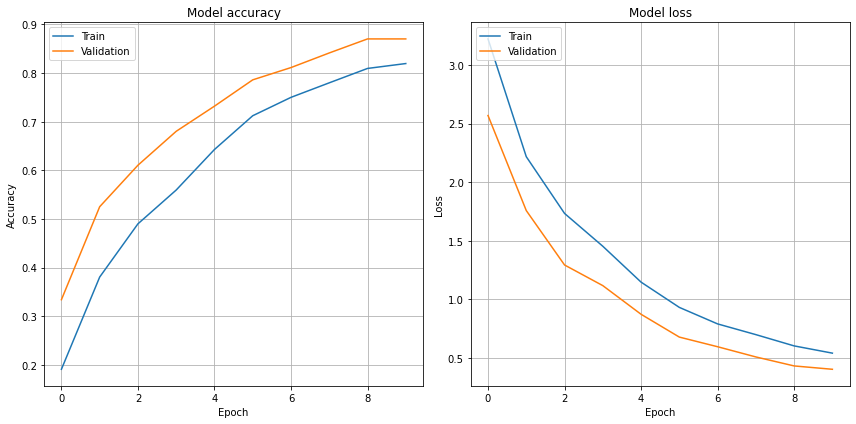

In [7]:
# Plot training history
plt.figure(figsize=(12,6))

# Plot training and validation accuracy values
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training and validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# save the entire model
model.save('model.h5')   